## Install libraries

In [1]:
%pip install yt_dlp

  Using cached yt_dlp-2025.9.26-py3-none-any.whl.metadata (175 kB)
Using cached yt_dlp-2025.9.26-py3-none-any.whl (3.2 MB)


## Step 1a - Indexing (Document Ingestion)

## Downloading the transcript through the subtitles using the cookies

In [27]:
import yt_dlp
import os
import re

def download_single_video_subtitles_with_cookies(video_url, cookie_file_path, lang='en'):
    """
    Downloads all subtitles from a single YouTube video using a cookies.txt file.
    Saves them as .vtt files in the current folder.
    """
    current_directory = os.getcwd()
    print(f"Saving subtitles to: {current_directory}")
    print(f"Using cookie file: {cookie_file_path}")

    if not os.path.exists(cookie_file_path):
        print(f"❌ ERROR: Cookie file not found at '{cookie_file_path}'")
        return

    ydl_opts = {
        'skip_download': True,              # don’t download video
        'writeautomaticsub': True,          # fetch auto-generated subs if needed
        'subtitleslangs': [lang],           # target language
        'subtitlesformat': 'vtt',           # save as .vtt
        'ignoreerrors': True,
        'cookies': cookie_file_path,
        'outtmpl': '%(title)s.%(ext)s',  # Modified outtmpl for single video
        'quiet': False,
    }

    try:
        with yt_dlp.YoutubeDL(ydl_opts) as ydl:
            ydl.download([video_url]) # Pass single video URL as a list
        print(f"\n✅ Finished downloading subtitles for the video!")
    except Exception as e:
        print(f"❌ An error occurred: {e}")



In [28]:
# --- Example usage ---
# Replace with the actual video URL you want to download subtitles for
my_video_url = "https://youtu.be/fNk_zzaMoSs?si=_MyHrPQQdT5qFU-E"
my_cookie_file = "cookies.txt"

download_single_video_subtitles_with_cookies(my_video_url, my_cookie_file)

Saving subtitles to: /media/rgukt/data/RAG/6_youtube_transcript
Using cookie file: cookies.txt
[youtube] Extracting URL: https://youtu.be/fNk_zzaMoSs?si=_MyHrPQQdT5qFU-E
[youtube] fNk_zzaMoSs: Downloading webpage
[youtube] fNk_zzaMoSs: Downloading tv client config
[youtube] fNk_zzaMoSs: Downloading tv player API JSON
[youtube] fNk_zzaMoSs: Downloading web safari player API JSON
[youtube] fNk_zzaMoSs: Downloading m3u8 information
[info] fNk_zzaMoSs: Downloading subtitles: en
[info] fNk_zzaMoSs: Downloading 1 format(s): 399+251-9
[info] Writing video subtitles to: Vectors ｜ Chapter 1, Essence of linear algebra.en.vtt


[download] Destination: Vectors ｜ Chapter 1, Essence of linear algebra.en.vtt
[download] 100% of   89.51KiB in 00:00:00 at 420.31KiB/s

✅ Finished downloading subtitles for the video!


## Cleaning the text

In [29]:
import os
import re

def clean_vtt(vtt_file):
    """
    Reads a .vtt file and removes:
    - timestamps like <00:00:01.234>
    - <c> tags
    - align:start... metadata
    - empty lines
    Returns clean plain text.
    """
    with open(vtt_file, 'r', encoding='utf-8') as f:
        text = f.read()

    # Remove WEBVTT header and metadata lines
    text = re.sub(r'WEBVTT.*\n', '', text)
    text = re.sub(r'(Kind:.*|Language:.*|align:start.*|position:.*)', '', text, flags=re.IGNORECASE)

    # Remove timestamps
    text = re.sub(r'<\d{2}:\d{2}:\d{2}\.\d{3}>', '', text)  # <00:00:01.234>
    text = re.sub(r'\d{2}:\d{2}:\d{2}\.\d{3} --> \d{2}:\d{2}:\d{2}\.\d{3}', '', text)

    # Remove <c> tags
    text = re.sub(r'</?c>', '', text)

    # Remove extra blank lines
    text = re.sub(r'\n+', '\n', text)

    # Remove repeated lines if necessary
    lines = text.split('\n')
    cleaned_lines = []
    for line in lines:
        line = line.strip()
        if line and (not cleaned_lines or line != cleaned_lines[-1]):
            cleaned_lines.append(line)

    return ' '.join(cleaned_lines)

# --- Usage for a single file ---
vtt_file_path = "Vectors ｜ Chapter 1, Essence of linear algebra.en.vtt"
if os.path.exists(vtt_file_path):
    clean_text = clean_vtt(vtt_file_path)

    print(f"\n--- Cleaned Transcript for: {os.path.basename(vtt_file_path)} ---\n")
    print(clean_text)

    # Optionally, save the cleaned text to a new file
    txt_path = vtt_file_path.replace('.vtt', '.clean.txt')
    with open(txt_path, 'w', encoding='utf-8') as f:
        f.write(clean_text)
    print(f"✅ Clean transcript saved to: {txt_path}")
else:
    print(f"❌ ERROR: File not found at '{vtt_file_path}'")


--- Cleaned Transcript for: Vectors ｜ Chapter 1, Essence of linear algebra.en.vtt ---

[Music] the fundamental root of itall building block for linear algebra is the vector so it's worth making sure that we're all on the same page about what exactly a vector is you see broadly speaking there are three distinct but related ideas about vectors which I'll call the physics student perspective the computer science student perspective and the mathematicians perspective the physics student perspective is that vectors are arrows pointing in space what defines a given Vector is its length and the direction its pointing but as long as those two facts are the same you can move it all around and it's still the same Vector vectors that live in the flat plane are two-dimensional and those sitting in broader space that you and I live in are three-dimensional the computer science perspective is that vectors are ordered lists of numbers for example let's say you were doing some analytics about house p

In [30]:
print(len(clean_text))

9879


In [32]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_google_genai import GoogleGenerativeAIEmbeddings,ChatGoogleGenerativeAI
from langchain_community.vectorstores import FAISS
from langchain.prompts import PromptTemplate

## Step 1b - Indexing (Text Splitting)

In [33]:
splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap = 200
)

In [34]:
chunks = splitter.create_documents([clean_text])

In [35]:
len(chunks)

13

In [36]:
chunks[0]

Document(metadata={}, page_content="[Music] the fundamental root of itall building block for linear algebra is the vector so it's worth making sure that we're all on the same page about what exactly a vector is you see broadly speaking there are three distinct but related ideas about vectors which I'll call the physics student perspective the computer science student perspective and the mathematicians perspective the physics student perspective is that vectors are arrows pointing in space what defines a given Vector is its length and the direction its pointing but as long as those two facts are the same you can move it all around and it's still the same Vector vectors that live in the flat plane are two-dimensional and those sitting in broader space that you and I live in are three-dimensional the computer science perspective is that vectors are ordered lists of numbers for example let's say you were doing some analytics about house prices and the only features you cared about were squ

## Step 1c & 1d - Indexing (Embedding Generation and Storing in Vector Store)

In [37]:
from dotenv import load_dotenv
load_dotenv()

True

In [38]:
embeddings= GoogleGenerativeAIEmbeddings(
        model="models/gemini-embedding-001",
        task_type="retrieval_query"  # Specify the task type
    )

E0000 00:00:1760161637.827117   14787 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


In [39]:
vector_store = FAISS.from_documents(chunks,embedding=embeddings)

In [40]:
vector_store.index_to_docstore_id

{0: 'd7e396ac-ca75-49fc-b755-88c21703f1f9',
 1: '03cc5ea4-c748-490c-9f29-829fc9e93d83',
 2: 'b8f82a5b-c659-4eee-8860-388260e4e991',
 3: '76374d32-ee6c-480a-a1f2-b83c2ef4d261',
 4: 'f4d8fd01-1ccf-44f9-95b1-14e6bc0c811f',
 5: 'a0132f5e-65e6-4ffe-82c6-11777a0ca9e3',
 6: '66ae25a5-96f2-4cc3-810b-999b137da810',
 7: 'b97f969b-0675-4dcd-981d-0a23edd199aa',
 8: 'bdd497a9-42fe-4bf7-b6e2-a6728e45fe18',
 9: 'e51c4ddd-4478-46e9-ad1a-c5d65f8179ff',
 10: '254f6295-dab3-4f7c-b678-1e90b194d507',
 11: '58c9f7f7-5ede-45a5-925c-b14f2c3a925a',
 12: 'a3b38f72-9f07-475b-8114-baa7e37ebfe2'}

In [48]:
id1 = vector_store.get_by_ids(['d7e396ac-ca75-49fc-b755-88c21703f1f9'])

In [53]:
len(id1[0].page_content)

995

In [54]:
print(id1[0].page_content)

[Music] the fundamental root of itall building block for linear algebra is the vector so it's worth making sure that we're all on the same page about what exactly a vector is you see broadly speaking there are three distinct but related ideas about vectors which I'll call the physics student perspective the computer science student perspective and the mathematicians perspective the physics student perspective is that vectors are arrows pointing in space what defines a given Vector is its length and the direction its pointing but as long as those two facts are the same you can move it all around and it's still the same Vector vectors that live in the flat plane are two-dimensional and those sitting in broader space that you and I live in are three-dimensional the computer science perspective is that vectors are ordered lists of numbers for example let's say you were doing some analytics about house prices and the only features you cared about were square footage and price you might


## Step 2 - Retrieval

In [56]:
retriever = vector_store.as_retriever(
    search_type = 'similarity',
    search_kwargs = {'k':4}
)

In [57]:
retriever

VectorStoreRetriever(tags=['FAISS', 'GoogleGenerativeAIEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x786af87ef7f0>, search_kwargs={'k': 4})

In [58]:
retriever.invoke('what is the vector')

[Document(id='f4d8fd01-1ccf-44f9-95b1-14e6bc0c811f', metadata={}, page_content="which you should think of as the center of space and the root of all vectors after choosing an arbitrary length to represent one you make tick marks on each axis to represent this distance when I want to convey the idea of 2D space as a whole which you'll see comes up a lot in these videos I'll extend these tick marks to make grid lines but right now they'll actually get a little bit in the way the coordinates of a vector is a pair of numbers that basically gives instructions for how to get from the tail of that Vector at the origin to its tip the first number tells you how far to walk along the x-axis positive numbers indicating rightward motion negative numbers indicating leftward motion and the second number tells you how far to walk parallel to the y- AIS after that positive numbers indicating upward motion and negative numbers indicating downward motion to distinguish vectors from points the convention

## Step 3 - Augmentation

In [70]:
llm = ChatGoogleGenerativeAI(model = 'gemini-2.5-flash')

E0000 00:00:1760162759.681279   14787 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


In [60]:
Prompt = PromptTemplate(
    
    template="""
      You are a helpful assistant.
      Answer ONLY from the provided transcript context.
      If the context is insufficient, just say you don't know.

      {context}
      Question: {question}
    """,
    input_variables = ['context', 'question']
)


In [61]:
question = "for what topic in this video is discussing about?"
retriever_docs = retriever.invoke(question)

In [62]:
retriever_docs

[Document(id='a3b38f72-9f07-475b-8114-baa7e37ebfe2', metadata={}, page_content="on the screen and doing that usually relies on a lot of linear algebra understanding so there are your vector Basics and in the next video video I'll start getting into some pretty neat Concepts surrounding vectors like span bases and linear dependence see you then [Music]"),
 Document(id='b8f82a5b-c659-4eee-8860-388260e4e991', metadata={}, page_content="in this video the details of this view are rather abstract and I actually think it's healthy to ignore it until the last video of this series favoring a more concrete setting in the interim but the reason I bring it up here is that it hints at the fact that the ideas of vector addition and multiplication by numbers will play an important role throughout linear algebra but before I talk about those operations let's just settle in on a specific thought to have in mind when I say the word Vector given the geometric Focus that I'm shooting for here whenever I i

In [63]:
context_text = "\n\n".join(doc.page_content for doc in retriever_docs)
context_text

"on the screen and doing that usually relies on a lot of linear algebra understanding so there are your vector Basics and in the next video video I'll start getting into some pretty neat Concepts surrounding vectors like span bases and linear dependence see you then [Music]\n\nin this video the details of this view are rather abstract and I actually think it's healthy to ignore it until the last video of this series favoring a more concrete setting in the interim but the reason I bring it up here is that it hints at the fact that the ideas of vector addition and multiplication by numbers will play an important role throughout linear algebra but before I talk about those operations let's just settle in on a specific thought to have in mind when I say the word Vector given the geometric Focus that I'm shooting for here whenever I introduce a new topic involving vectors I want you to First think about an arrow and specifically think about that Arrow inside a coordinate system like the XY 

In [65]:
final_prompt = Prompt.invoke({'context':context_text,'question':question})

In [66]:
final_prompt

StringPromptValue(text="\n      You are a helpful assistant.\n      Answer ONLY from the provided transcript context.\n      If the context is insufficient, just say you don't know.\n\n      on the screen and doing that usually relies on a lot of linear algebra understanding so there are your vector Basics and in the next video video I'll start getting into some pretty neat Concepts surrounding vectors like span bases and linear dependence see you then [Music]\n\nin this video the details of this view are rather abstract and I actually think it's healthy to ignore it until the last video of this series favoring a more concrete setting in the interim but the reason I bring it up here is that it hints at the fact that the ideas of vector addition and multiplication by numbers will play an important role throughout linear algebra but before I talk about those operations let's just settle in on a specific thought to have in mind when I say the word Vector given the geometric Focus that I'm

## Step 4 - Generation

In [71]:
answer = llm.invoke(final_prompt)
print(answer.content)

The video is discussing vector basics, including different ways to conceptualize vectors (as arrows in a coordinate system, as ordered lists of numbers, and abstractly), and hints at operations like vector addition and multiplication by numbers, all within the context of linear algebra.


## Building a Chain

In [72]:
## Building a Chain

In [73]:
from langchain_core.runnables import RunnableLambda,RunnableParallel,RunnablePassthrough

from langchain_core.output_parsers import StrOutputParser

In [74]:
def format_docs(retrieved_docs):
    context_text = "\n\n".join(doc.page_content for doc in retrieved_docs)
    return context_text

In [75]:
parallel_chain = RunnableParallel(
    {
        'context': retriever | RunnableLambda(format_docs),
        'question':RunnablePassthrough()
    }
)

In [77]:
parallel_chain.invoke('what is this video about ?')

{'context': "on the screen and doing that usually relies on a lot of linear algebra understanding so there are your vector Basics and in the next video video I'll start getting into some pretty neat Concepts surrounding vectors like span bases and linear dependence see you then [Music]\n\nin this video the details of this view are rather abstract and I actually think it's healthy to ignore it until the last video of this series favoring a more concrete setting in the interim but the reason I bring it up here is that it hints at the fact that the ideas of vector addition and multiplication by numbers will play an important role throughout linear algebra but before I talk about those operations let's just settle in on a specific thought to have in mind when I say the word Vector given the geometric Focus that I'm shooting for here whenever I introduce a new topic involving vectors I want you to First think about an arrow and specifically think about that Arrow inside a coordinate system 

In [78]:
parser = StrOutputParser()

In [79]:
main_chain = parallel_chain | Prompt | llm | parser

In [80]:
main_chain.invoke('can you summarize the video')

"The video discusses two main ways to think about vectors: as ordered lists of numbers (e.g., square footage and price of a house) and as arrows in space, originating from the origin. The usefulness of linear algebra comes from the ability to translate between these two views. This allows data analysts to visualize patterns in data and helps physicists and computer graphics programmers describe and manipulate space numerically. The coordinates of a vector provide instructions on how to move from the origin to the vector's tip, with the first number indicating motion along the x-axis and the second along the y-axis. The next video will delve into concepts like span, bases, and linear dependence."

In [112]:
graph = parallel_chain.get_graph()

print("📊 Graph Structure:")
print("=" * 50)

for node_id, node in graph.nodes.items():
    print(f"🟢 Node: {node.name}")
    if hasattr(node.data, '__class__'):
        print(f"   Type: {node.data.__class__.__name__}")
    print(f"   ID: {node_id}\n")

print("=" * 50)
print("🔗 Edges:")
for edge in graph.edges:
    src = graph.nodes[edge.source].name
    tgt = graph.nodes[edge.target].name
    print(f"   {src}  --->  {tgt}")


📊 Graph Structure:
🟢 Node: Parallel<context,question>Input
   Type: ModelMetaclass
   ID: 9f7d64eb867247e8b5bca03743b2074d

🟢 Node: Parallel<context,question>Output
   Type: ModelMetaclass
   ID: 2cf703324e344ef78544b8581e5c1943

🟢 Node: VectorStoreRetriever
   Type: VectorStoreRetriever
   ID: 4c1c49fe76c0429385972f7f88aa81bf

🟢 Node: format_docs
   Type: RunnableLambda
   ID: bf22d861e3054bd4b86b2bc2272f21f8

🟢 Node: Passthrough
   Type: RunnablePassthrough
   ID: 94b8cac4a6d34f4ebb4ef179984be8e3

🔗 Edges:
   VectorStoreRetriever  --->  format_docs
   Parallel<context,question>Input  --->  VectorStoreRetriever
   format_docs  --->  Parallel<context,question>Output
   Parallel<context,question>Input  --->  Passthrough
   Passthrough  --->  Parallel<context,question>Output


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 1.5 MB/s  0:00:05 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 2.7 MB/s  0:00:01 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 3.0 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [matplotlib]5 [matplotlib]


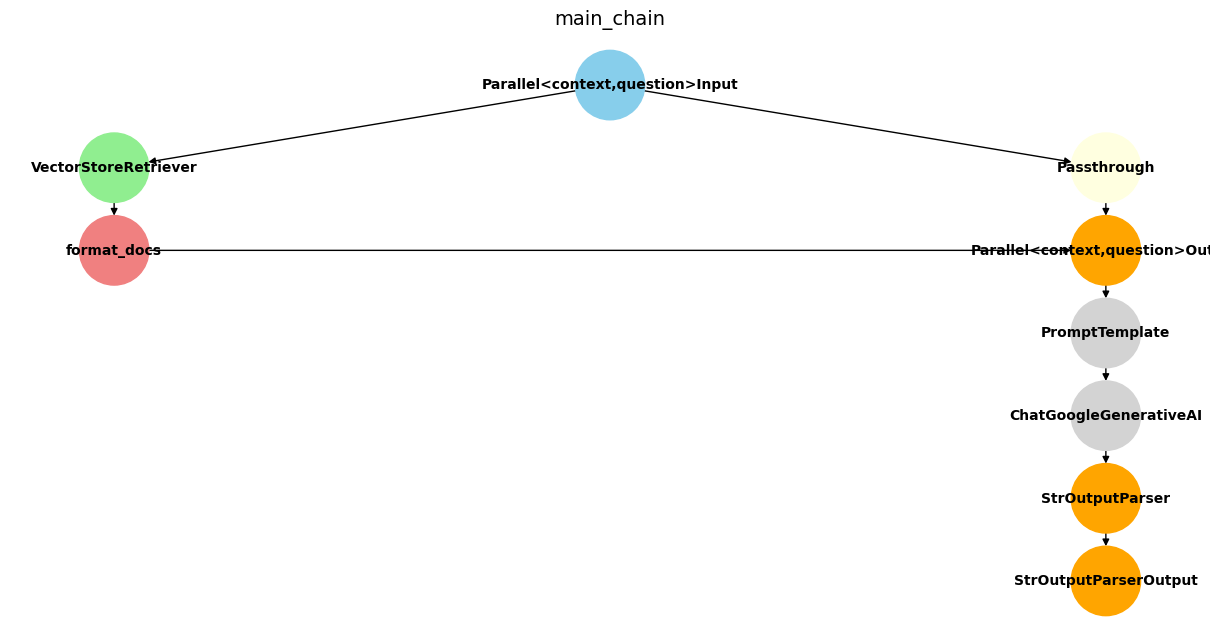

In [132]:
import networkx as nx
import matplotlib.pyplot as plt

def draw_langchain_graph(graph, title="LangChain Graph"):
    """
    Draws a hierarchical (top-down) flow of any LangChain Runnable graph.
    
    Args:
        graph: LangChain graph object (from .get_graph())
        title: Plot title
    """
    G = nx.DiGraph()

    # Add nodes with type info
    node_colors = []
    for node_id, node in graph.nodes.items():
        G.add_node(node_id, label=node.name)
        
        # Color-code by type
        node_type = type(getattr(node, 'data', None)).__name__
        if 'Retriever' in node_type:
            node_colors.append('lightgreen')
        elif 'Lambda' in node_type:
            node_colors.append('lightcoral')
        elif 'Passthrough' in node_type:
            node_colors.append('lightyellow')
        elif 'Input' in node.name:
            node_colors.append('skyblue')
        elif 'Output' in node.name:
            node_colors.append('orange')
        else:
            node_colors.append('lightgrey')

    # Add edges
    for edge in graph.edges:
        G.add_edge(edge.source, edge.target)

    # Hierarchical layout (top-down)
    def hierarchy_pos(G, root=None, width=1.0, vert_gap=0.2, xcenter=0.5):
        if root is None:
            root = list(nx.topological_sort(G))[0]

        def _hierarchy_pos(G, root, left, right, vert_pos=0, pos=None, parent=None):
            if pos is None:
                pos = {}
            pos[root] = ((left + right) / 2, -vert_pos)
            children = list(G.successors(root))
            if len(children) != 0:
                dx = (right - left) / len(children)
                nextx = left
                for child in children:
                    next_right = nextx + dx
                    pos = _hierarchy_pos(G, child, nextx, next_right, vert_pos + vert_gap, pos, root)
                    nextx += dx
            return pos

        return _hierarchy_pos(G, root, 0, width)

    pos = hierarchy_pos(G)

    # Draw graph
    plt.figure(figsize=(12, 6))
    labels = {n: G.nodes[n]['label'] for n in G.nodes}
    nx.draw(G, pos, labels=labels, with_labels=True, arrows=True,
            node_size=2500, node_color=node_colors, font_size=10, font_weight="bold")
    plt.title(title, fontsize=14)
    plt.axis('off')
    plt.show()


# Usage example with any Runnable graph:
graph = main_chain.get_graph()
draw_langchain_graph(graph, title="main_chain")


### Drawing int he png

In [131]:
# Assuming you have the same 'chain' as defined above
main_chain.get_graph().draw_png(output_file_path="chain_diagram.png")


/media/rgukt/data/RAG/venv/lib/python3.10/site-packages/pygraphviz/agraph.py:1403: RuntimeWarning: Error: not well-formed (invalid token) in line 1 
... Parallel<context,question> ...
in label of node 4f47e86b502547e888963cfa271c4bdf
Error: not well-formed (invalid token) in line 1 
... Parallel<context,question> ...
in label of node 6eff7957bc7a46eba193bce79dccd82e

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


## Building another one 

In [138]:
download_single_video_subtitles_with_cookies('https://youtu.be/kCc8FmEb1nY?si=SO1hc8lLQDY1QTBa','cookies.txt')

Saving subtitles to: /media/rgukt/data/RAG/6_youtube_transcript
Using cookie file: cookies.txt
[youtube] Extracting URL: https://youtu.be/kCc8FmEb1nY?si=SO1hc8lLQDY1QTBa
[youtube] kCc8FmEb1nY: Downloading webpage
[youtube] kCc8FmEb1nY: Downloading tv client config
[youtube] kCc8FmEb1nY: Downloading tv player API JSON
[youtube] kCc8FmEb1nY: Downloading web safari player API JSON
[youtube] kCc8FmEb1nY: Downloading m3u8 information
[info] kCc8FmEb1nY: Downloading subtitles: en
[info] kCc8FmEb1nY: Downloading 1 format(s): 401+251
[info] Writing video subtitles to: Let's build GPT： from scratch, in code, spelled out..en.vtt


[download] Destination: Let's build GPT： from scratch, in code, spelled out..en.vtt
[download] 100% of 1012.61KiB in 00:00:01 at 931.92KiB/s

✅ Finished downloading subtitles for the video!


In [139]:
clean_text = clean_vtt('build GPT： from scratch, in code, spelled out..en.vtt')

108990